In [ ]:
!pip install torchinfo

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
import torchinfo
from torchinfo import summary

In [ ]:
train_dir = '/content/lungs-disease-dataset-4-types/dataset/train'
test_dir = '/content/lungs-disease-dataset-4-types/dataset/test'
val_dir = '/content/lungs-disease-dataset-4-types/dataset/val'

BATCH_SIZE = 32

# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
from torchvision import datasets
# Turn image folders into Datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform=train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 6054
     Root location: /content/lungs-disease-dataset-4-types/Lung Disease Dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 2025
     Root location: /content/lungs-disease-dataset-4-types/Lung Disease Dataset/test
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [ ]:
import os

NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_simple

(<torch.utils.data.dataloader.DataLoader at 0x7b26979cfdf0>,
 <torch.utils.data.dataloader.DataLoader at 0x7b26979cf460>)

In [ ]:
import torch.nn as nn
from torchsummary import summary

def dwise_conv(ch_in, stride=1):
    return (
        nn.Sequential(
            #depthwise
            nn.Conv2d(ch_in, ch_in, kernel_size=3, padding=1, stride=stride, groups=ch_in, bias=False),
            nn.BatchNorm2d(ch_in),
            nn.ReLU6(inplace=True),
        )
    )

def conv1x1(ch_in, ch_out):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=1, padding=0, stride=1, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

def conv3x3(ch_in, ch_out, stride):
    return (
        nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(ch_out),
            nn.ReLU6(inplace=True)
        )
    )

class InvertedBlock(nn.Module):
    def __init__(self, ch_in, ch_out, expand_ratio, stride):
        super(InvertedBlock, self).__init__()

        self.stride = stride
        assert stride in [1,2]

        hidden_dim = ch_in * expand_ratio

        self.use_res_connect = self.stride==1 and ch_in==ch_out

        layers = []
        if expand_ratio != 1:
            layers.append(conv1x1(ch_in, hidden_dim))
        layers.extend([
            #dw
            dwise_conv(hidden_dim, stride=stride),
            #pw
            conv1x1(hidden_dim, ch_out)
        ])

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.layers(x)
        else:
            return self.layers(x)

class MobileNetV2(nn.Module):
    def __init__(self, ch_in=3, n_classes=5):
        super(MobileNetV2, self).__init__()

        self.configs=[
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        self.stem_conv = conv3x3(ch_in, 32, stride=2)

        layers = []
        input_channel = 32
        for t, c, n, s in self.configs:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedBlock(ch_in=input_channel, ch_out=c, expand_ratio=t, stride=stride))
                input_channel = c

        self.layers = nn.Sequential(*layers)

        self.last_conv = conv1x1(input_channel, 1280)

        self.classifier = nn.Sequential(
            nn.Dropout2d(0.2),
            nn.Linear(1280, n_classes)
        )
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        x = self.stem_conv(x)
        x = self.layers(x)
        x = self.last_conv(x)
        x = self.avg_pool(x).view(-1, 1280)
        x = self.classifier(x)
        return x


model = MobileNetV2(ch_in=3, n_classes=5)
summary(model, (3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
             ReLU6-9         [-1, 16, 112, 112]               0
    InvertedBlock-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 96, 112, 112]           1,536
      BatchNorm2d-12         [-1, 96, 112, 112]             192
            ReLU6-13         [-1, 96, 112, 112]               0
           Conv2d-14           [-1, 96,

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [ ]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [ ]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 20):

    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }

    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)

        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [ ]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 50

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

modal=model.to(device)

# Train model
model_results = train(model=model,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.3038 | train_acc: 0.4499 | test_loss: 0.9915 | test_acc: 0.5410
Epoch: 2 | train_loss: 1.0373 | train_acc: 0.5711 | test_loss: 0.7706 | test_acc: 0.7049
Epoch: 3 | train_loss: 0.9059 | train_acc: 0.6314 | test_loss: 0.6199 | test_acc: 0.7457
Epoch: 4 | train_loss: 0.8076 | train_acc: 0.6782 | test_loss: 0.6255 | test_acc: 0.7426
Epoch: 5 | train_loss: 0.7546 | train_acc: 0.6869 | test_loss: 0.5398 | test_acc: 0.7735
Epoch: 6 | train_loss: 0.6963 | train_acc: 0.7120 | test_loss: 0.6952 | test_acc: 0.7197
Epoch: 7 | train_loss: 0.6867 | train_acc: 0.7203 | test_loss: 0.5509 | test_acc: 0.7776
Epoch: 8 | train_loss: 0.6427 | train_acc: 0.7365 | test_loss: 0.4808 | test_acc: 0.7837
Epoch: 9 | train_loss: 0.5916 | train_acc: 0.7549 | test_loss: 0.4556 | test_acc: 0.8053
Epoch: 10 | train_loss: 0.6235 | train_acc: 0.7492 | test_loss: 0.5501 | test_acc: 0.7754
Epoch: 11 | train_loss: 0.5805 | train_acc: 0.7644 | test_loss: 0.6593 | test_acc: 0.7415
Epoch: 12 | train_l

In [ ]:
from matplotlib import pyplot as plt
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """

    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

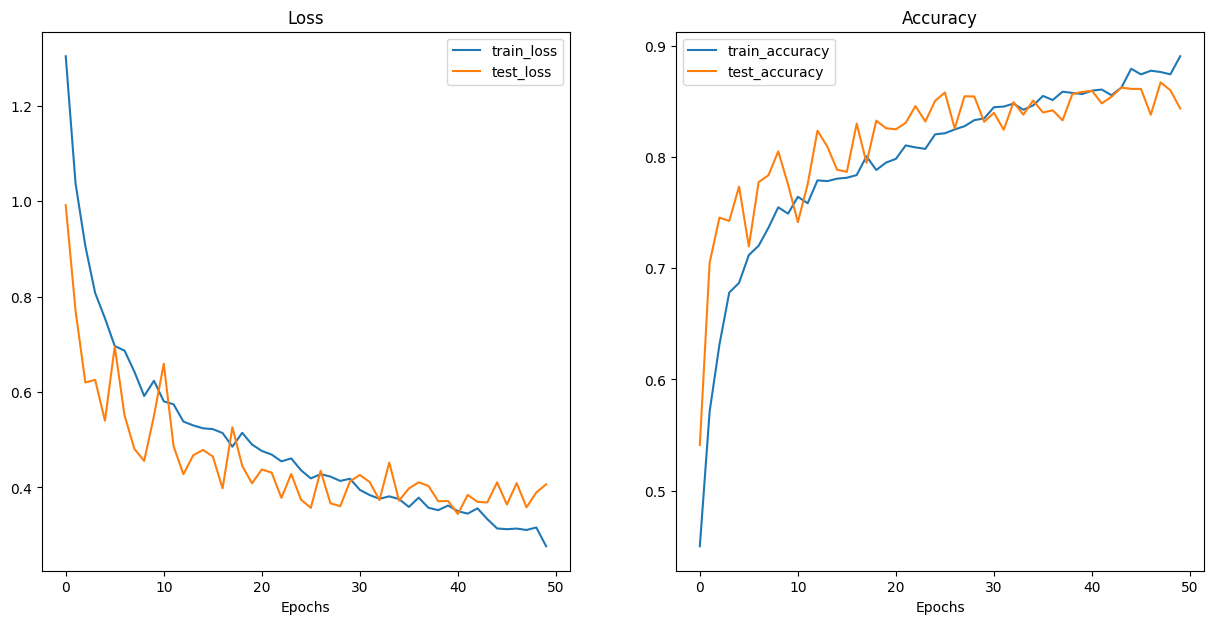

In [ ]:
plot_loss_curves(model_results)